<a href="https://colab.research.google.com/github/Jaseelkt007/Generative_AI_basics/blob/main/Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Diffusion models

Implementing the DDPM 2020 paper


The main idea with score based models is that, instead of modeling data using probability density pdf, we model the data using the score,

This has two process:
* Forward process (Diffusion process) : Change a give input $x_0$ to a Guassian noise $x_t$ ~ $N(0,I)$ by a sequence of first order markov process $q(x_t/x_{t-1})$ ,

* Reverse process (Generation process) : Reverse the diffustion process, by converting the Noise to original data.


# Diffusion Model Equations

## Forward/noising (fixed, known):

$$q(\mathbf{x}_t \mid \mathbf{x}_{t-1}) = \mathcal{N}\big(\sqrt{\alpha_t}\,\mathbf{x}_{t-1},\, (1-\alpha_t)\mathbf{I}\big), \qquad \alpha_t = 1 - \beta_t$$

## Closed form:

$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t}\,\boldsymbol{\epsilon}$$

where:
$$\bar{\alpha}_t = \prod_{s=1}^t \alpha_s, \qquad \boldsymbol{\epsilon} \sim \mathcal{N}(0,I)$$

## Model & loss (ε-prediction):

$$\mathcal{L} = \mathbb{E}_{\mathbf{x}_0,t,\boldsymbol{\epsilon}}\big[\|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t,t)\|^2\big]$$

## Reverse/denoising (ancestral DDPM step):

$$p_\theta(\mathbf{x}_{t-1}\mid \mathbf{x}_t) = \mathcal{N}\!\big(\boldsymbol{\mu}_\theta(\mathbf{x}_t,t),\ \sigma_t^2 I\big)$$

where:
$$\boldsymbol{\mu}_\theta = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\ \boldsymbol{\epsilon}_\theta(\mathbf{x}_t,t)\right)$$

$$\sigma_t^2 = \beta_t$$

In [3]:
# Create a toy dataset
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


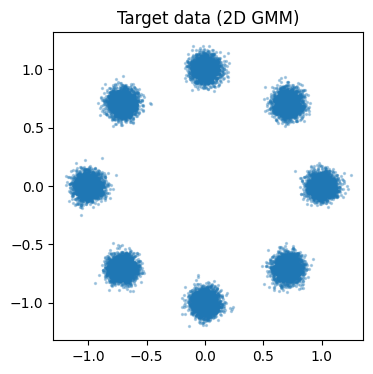

In [4]:
class GMM2D(Dataset):
    def __init__(self, n=3000, std=0.06, K=8):
        self.n = n
        angles = np.linspace(0, 2*np.pi , K , endpoint=False)
        centers = np.stack([np.cos(angles), np.sin(angles)], axis=1).astype(np.float32)
        idx = torch.randint(0,K, (n,))
        base = torch.tensor(centers)[idx]
        self.data = base + std*torch.randn(n,2)

    def __len__(self): return self.n
    def __getitem__(self, i): return self.data[i]

dataset = GMM2D(n=20000, std=0.06)
loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

pts = dataset.data.numpy()
plt.figure(figsize=(4,4)); plt.scatter(pts[:,0], pts[:,1], s=2, alpha=0.3)
plt.axis('equal'); plt.title("Target data (2D GMM)"); plt.show()